# Assignment 1: Colors

### Problem description and approach
Given a set of 5 colors, and a target color, we need to find the combination of 3 colors and their respective proportions in order to obtain a color that resembles target.  

We view the problem as follows:
- Given some 'objective' function, that takes in inputs (here, the 3 input colors and their respective ratios) and returns the target color, what are the input parameters that minimizes the value of the objective function?
- The 'shape/graph' of the objective function is not known to us initially. Furthermore, we assume that evaluating (calling) this objective function is very expensive.
- Thus, from an abstract level, we view the problem of finding the optimal inputs to the objective function without evaluating it at every point.

This is a direct application of Bayesian Optimization.

Formally, Bayesian Optimization is a class of machine-learning-based optimization methods focused on solving the problem ```argmax(f(x))```, where 'f' is the objective function and x is a d-dimensional vector of real numbers. Typically, d is not too large. In our example, d = 3, we repeat the bayesian optimization for every combination of 3 colors out of 5 available, and then choose the best combination.

### Code structure
This python notebook has the implementation of the bayesian optimization, and the utility functions provided by Prof. Foster are in a seperate python module - ```colors_util.py```.

In [49]:
# import sys
# !{sys.executable} -m pip install colormath

import scipy.stats
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
import math
from colors_util import show_colors, combine_colors, color_diff, construct_color, random_color
import itertools

In [50]:
# Our aim is to maximize this objective function.
# Assumption is that calling the objective function is expensive.
# Hence, we must call this as less as possible.
def objective(X, colors, target_color):
    assert(len(X) == 3)
    assert(len(colors) == 3)
    combination = combine_colors(colors[0], X[0], colors[1], X[1], colors[2], X[2])
    return -color_diff(target_color, combination)

In [51]:
# We approximate the objective function using a surrogate
# This approximation gets better as more data points are explored
# In bayesian terms, initially, this represents the prior distribution of approximated objective
# As we evaluate datapoints, it represents a posterior distribution
def surrogate(model, X):
    return model.predict(X, return_std=True)

# After we 'learn' an approximation from our observations so far,
# the acquisition function tells us that given the current surrogate,
# what is the 'scores' of exploring a given input point.
# There are many choices. Here, I have used a probability of improvement acquisition function
def acquisition(X, Xsamples, model):
    yhat, _ = surrogate(model, X)
    best = max(yhat)

    # Calculate mean and std dev via surrogate
    mu, std = surrogate(model, Xsamples)
    mu = mu[0]

    # calculate the probability of improvement
    probs = scipy.stats.norm.cdf((mu - best) / (std+1E-9))
    return probs

# Optimize the acquisition function
def opt_acquisition(X, model):
    random_points = 120000 # another hyperparameter
    Xsamples = np.random.random(random_points)
    Xsamples = Xsamples.reshape(random_points//3, 3)

    # calculate the acquisition score for each point
    scores = acquisition(X, Xsamples, model)

    # locate the index of the largest score
    ix = np.argmax(scores)
    return Xsamples[ix]

In [88]:
# Takes in 3 colors and finds a combination to estimate target
def bayes_opt(target, colors, threshold=-10):
    num_starting_points = 10
    X = np.random.random(3 * num_starting_points).reshape(num_starting_points, 3)
    for i in range(num_starting_points):
        x = X[i]
        normalized_x = x / x.sum()
        X[i] = normalized_x

    y = np.asarray([objective(x, colors, target) for x in X])
    y = y.reshape(len(y), 1)

    model = GaussianProcessRegressor()
    model.fit(X, y)

    best_y_so_far = y[np.argmax(y)]
    print("init", best_y_so_far)

    num_experiments = num_starting_points

    while(best_y_so_far < threshold):
        # select next point to sample
        x = opt_acquisition(X, model)

        actual = objective(x, colors, target)
        num_experiments += 1

        if actual > best_y_so_far:
            best_y_so_far = actual
            best_x = x
            # print("Best found so far: ", best_x, best_y_so_far)

        surrogate(model, [x])
        X = np.vstack((X, x))
        y = np.vstack((y, [actual]))

        model.fit(X, y)

    ix = np.argmax(y)
    # print(y[ix], best_y_so_far)
    # assert(y[ix] == best_y_so_far)
    print("Best result: ", X[ix], y[ix])
    print(num_experiments)

    final_color = combine_colors(colors[0], X[ix][0], colors[1], X[ix][1], colors[2], X[ix][2])

    colors.append(target)
    colors.append(final_color)

    show_colors(colors)

init [-10.97888533]
Best result:  [0.28169465 0.38682917 0.74282069] [-9.28429922]
37


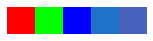

In [91]:
def find_a_good_combination(target, colors):
    assert(len(colors) >= 3)
    for colors_3_samples in itertools.combinations(colors, 3):
        bayes_opt(target, list(colors_3_samples), -5)


# First, we use the simple R-G-B example to validate our approach
red   = construct_color(1.0, 0.0, 0.0)
green = construct_color(0.0, 1.0, 0.0)
blue  = construct_color(0.0, 0.0, 1.0)

colors = [red, green, blue]
target = construct_color(0.123, 0.456, 0.789)

find_a_good_combination(target, colors)

### Comparision to naive uniform search
The uniform sampling strategy used 125 observations for finding an optimal mix of 3 colors. Here, we limit our number of observations to half that - 60 (10 initial + 50 iterations) and almost all of the times, obain a color that resembles the target much better than when we employed uniform search.

### Drawbacks of this technique
From the simple example above, we conclude a few drawbacks of our initial approach:
- The result is highly inconsistent. The difference between the target color and the one that we find may be as high as about 10, or as low as about 1.5. In comparision, the naive uniform strategy returned a consistent result with no variance. I attribute this to the random nature of a few steps of my initial approach - the inital points chosen to construct the first posterior and the points chosen thereafter to get the 'best next' point according to the surrogate (posterior) is fairly random. A bit of intelligence in these steps would be a possible area of improvement.
- This approach is very mathematically expensive - given that we use sophisticated mathematical models like the GaussianProcessRegressor, high number of floating point operations etc. It may be worthwile to evaluate if we are not exceeding the cost of using the objective function (color mix + color diff observe) itself. (Albeit these are different forms of 'expense': Color mixing and subsequent capturing color difference is a time consuming task as observed in the opentrons robot. A compute intensive approach like the one above may reduce the 'time' taken by bringing down the number of color mix + color diff observations, but the hardware costs may increase).

### Random colors

Available colors:


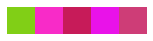

Target:


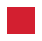

Best result:  [0.26334846 0.04739292 0.68925862] [-7.85647768]
100


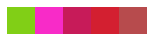

Best result:  [0.43131872 0.56192556 0.00675572] [-18.3230991]
100


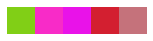

Best result:  [0.27379808 0.09140012 0.6348018 ] [-12.88766305]
100


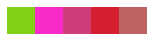

Best result:  [0.23554466 0.70925489 0.05520045] [-9.01895943]
100


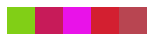

Best result:  [0.23428569 0.72981913 0.03589518] [-7.49557903]
100


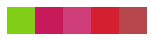

Best result:  [0.23028676 0.00625795 0.76345529] [-12.00543879]
100


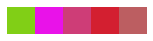

Best result:  [0.26091302 0.71784463 0.02124234] [-19.46454394]
100


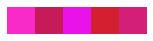

Best result:  [0.01060291 0.72177244 0.26762465] [-14.88672539]
100


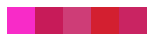

Best result:  [0.12133514 0.08490828 0.79375658] [-22.05427797]
100


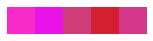

Best result:  [0.71884018 0.02275843 0.25840138] [-15.38704157]
100


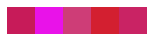

In [54]:
# np.random.seed(1)

colors = [random_color(), random_color(), random_color(), random_color(), random_color()]
target = random_color()

print('Available colors:')
show_colors(colors)

print("Target:")
show_colors([target])

find_a_good_combination(target, colors)

### References
[1]: https://arxiv.org/pdf/1807.02811.pdf - an excellent introduction to bayesian optimization  
[2]: https://towardsdatascience.com/the-beauty-of-bayesian-optimization-explained-in-simple-terms-81f3ee13b10f  
[3]: https://en.wikipedia.org/wiki/Bayesian_optimization  
[4]: https://machinelearningmastery.com/what-is-bayesian-optimization/
